In [21]:
# ==============================================================================
# CELLA 1: SETUP, CONFIGURAZIONE E CREAZIONE STRUTTURA
# ==============================================================================
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm

# --- 1. CONFIGURAZIONE CENTRALE (CONTROL CENTER) ---
CONFIG = {
    # Path di Input
    "BASE_DIR": os.getcwd(),
    "RAW_CSV_PATH": os.path.join("DATASET_ITA", "ITA_COMMENTI_POST_AUDIT.csv"),
    "VIDEO_DIR": os.path.join("DATASET_ITA", "Video"),

    # Path di Output (Tutto dentro DATASET_ITA)
    "OUTPUT_ROOT": os.path.join("DATASET_ITA", "PROCESSED_DATA"),
    
    # Sottocartelle (generate dinamicamente)
    "FRAMES_OUT_DIR": os.path.join("DATASET_ITA", "PROCESSED_DATA", "frames"),
    "SPLITS_OUT_DIR": os.path.join("DATASET_ITA", "PROCESSED_DATA", "splits"),

    # Parametri Estrazione Frame
    "N_FRAMES": 3,
    "IMG_SIZE": (336, 336),       # Qwen-VL preferisce multipli di 14/28, 336 è standard
    "IMG_EXT": ".jpg",

    # Parametri Split
    "SPLIT_SEED": 17170,
    "VAL_SIZE": 0.125,              # Percentuale Validation
    "TEST_SIZE": 0.175,            # Percentuale Test finale (Sacro)
}

# --- 2. SETUP SEED GLOBALE ---
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"🌱 Global Seed (SPLIT_SEED) impostato a: {seed}")

set_global_seed(CONFIG["SPLIT_SEED"])

# --- 3. CREAZIONE CARTELLE OUTPUT ---
print(f"\n📂 Configurazione Cartelle:")
# Creiamo prima la root poi le sottocartelle
for path in [CONFIG["OUTPUT_ROOT"], CONFIG["FRAMES_OUT_DIR"], CONFIG["SPLITS_OUT_DIR"]]:
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
        print(f"   ✅ Creata cartella: {path}")
    else:
        print(f"   ☑️  Già esistente: {path}")

# --- 4. VERIFICA INPUT ---
print(f"\n🔍 Verifica Input:")
# Check CSV
if os.path.exists(CONFIG["RAW_CSV_PATH"]):
    print(f"   ✅ CSV Trovato: {CONFIG['RAW_CSV_PATH']}")
else:
    print(f"   ❌ ERRORE: CSV non trovato in {CONFIG['RAW_CSV_PATH']}")

# Check Video
if os.path.exists(CONFIG["VIDEO_DIR"]):
    mp4_files = glob(os.path.join(CONFIG["VIDEO_DIR"], "*.mp4"))
    num_videos = len(mp4_files)
    if num_videos > 0:
        print(f"   ✅ Cartella Video Trovata: {CONFIG['VIDEO_DIR']} (Contiene {num_videos} file .mp4)")
    else:
        print(f"   ⚠️ WARNING: Cartella Video trovata ma SEMBRA VUOTA o non ha file .mp4")
else:
    print(f"   ❌ ERRORE: Cartella Video non trovata in {CONFIG['VIDEO_DIR']}")

# Salva la config per debug futuro
print(f"\n⚙️  Parametri Split: Train={(1 - CONFIG['TEST_SIZE'] - CONFIG['VAL_SIZE']):.1%}, Val={CONFIG['VAL_SIZE']:.1%}, Test={CONFIG['TEST_SIZE']:.1%}")

🌱 Global Seed (SPLIT_SEED) impostato a: 17170

📂 Configurazione Cartelle:
   ☑️  Già esistente: DATASET_ITA/PROCESSED_DATA
   ☑️  Già esistente: DATASET_ITA/PROCESSED_DATA/frames
   ☑️  Già esistente: DATASET_ITA/PROCESSED_DATA/splits

🔍 Verifica Input:
   ✅ CSV Trovato: DATASET_ITA/ITA_COMMENTI_POST_AUDIT.csv
   ✅ Cartella Video Trovata: DATASET_ITA/Video (Contiene 40 file .mp4)

⚙️  Parametri Split: Train=70.0%, Val=12.5%, Test=17.5%


In [22]:
# ==============================================================================
# CELLA 2: CARICAMENTO DATASET, CLEANING E VERIFICA VIDEO
# ==============================================================================
import pandas as pd
from glob import glob
import os

print("⏳ Caricamento Dataset...")

# 1. Caricamento CSV Diretto
df = pd.read_csv(CONFIG["RAW_CSV_PATH"], sep=',', dtype={'video_id': str})

initial_len = len(df)
print(f"   ✅ Caricato con successo: {initial_len} righe (commenti.")

# 2. Verifica Colonne
required_cols = ['video_id', 'Comment', 'Type']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"❌ ERRORE: Colonne errate. Trovate: {df.columns.tolist()} | Richieste: {required_cols}")

# 3. Pulizia Base & Normalizzazione
df = df.dropna(subset=['video_id', 'Comment']) # Via i nulli
df['Type'] = df['Type'].astype(str).str.lower().str.strip() # Normalizza le label

# 4. Filtro Esistenza Video Fisici
# Controlliamo quali video esistono davvero nella cartella
existing_mp4_paths = glob(os.path.join(CONFIG["VIDEO_DIR"], "*.mp4"))
existing_video_ids = set([os.path.splitext(os.path.basename(f))[0] for f in existing_mp4_paths])

print(f"   🎥 Video fisici trovati su disco: {len(existing_video_ids)}")

# Teniamo solo le righe il cui video esiste
df_clean = df[df['video_id'].isin(existing_video_ids)].copy()

# Report Tagli
lost_rows = len(df) - len(df_clean)
if lost_rows > 0:
    print(f"   ⚠️ RIMOSSE {lost_rows} righe perché il file video non esiste.")
else:
    print(f"   ✨ Integrità perfetta: Tutti i video del CSV sono presenti su disco!")

print(f"\n📊 DATASET PRONTO PER LO SPLIT:")
print(f"   🔹 Commenti Totali: {len(df_clean)}")
print(f"   🔹 Video Unici:     {df_clean['video_id'].nunique()}")

print("\n📈 Distribuzione Classi:")
print(df_clean['Type'].value_counts())

# 5. PROVA DEL 9 (Check Visivo Emoji)
print("\n👀 CHECK VISIVO (Se vedi anche emoji e caratteri <<critici>> qui sotto, è ok):")
print("-" * 50)
sample = df_clean.sample(min(5, len(df_clean)))
for idx, row in sample.iterrows():
    print(f"   [{row['Type']}] {row['Comment']}")
print("-" * 50)

⏳ Caricamento Dataset...
   ✅ Caricato con successo: 5031 righe (commenti.
   🎥 Video fisici trovati su disco: 40
   ✨ Integrità perfetta: Tutti i video del CSV sono presenti su disco!

📊 DATASET PRONTO PER LO SPLIT:
   🔹 Commenti Totali: 5031
   🔹 Video Unici:     40

📈 Distribuzione Classi:
Type
none           3783
denigration     900
sexual          258
flaming          67
racism           23
Name: count, dtype: int64

👀 CHECK VISIVO (Se vedi anche emoji e caratteri <<critici>> qui sotto, è ok):
--------------------------------------------------
   [denigration] WHAIT
   [none] 🥰🥰
   [none] io sono libero😂😂
   [none] non io sicuramente
   [none] Ma chi è 😅
--------------------------------------------------


In [23]:
# ==============================================================================
# CELLA 3: ESTRAZIONE FRAME (ROBUSTA, CON FALLBACK SEQUENZIALE)
# ==============================================================================
import cv2
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

# --- 1. Funzione Resize con Padding (Aspect Ratio Preservato) ---
def resize_with_padding(image, target_size):
    """
    Ridimensiona l'immagine mantenendo l'aspect ratio e aggiunge
    padding nero per raggiungere target_size = (H, W).
    """
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    return canvas

# --- 2. Estrazione Frame da Singolo Video (Logica Robusta) ---
def process_single_video(video_id):
    """
    Estrae esattamente CONFIG["N_FRAMES"] frame da un video.
    Strategia:
      1. Prova sampling uniforme veloce (Seek).
      2. Fallback a lettura sequenziale se il seek fallisce.
      3. Se il video è corto, duplica l'ultimo frame (Padding temporale).
    """
    video_filename = f"{video_id}.mp4"
    video_path = os.path.join(CONFIG["VIDEO_DIR"], video_filename)
    out_dir = os.path.join(CONFIG["FRAMES_OUT_DIR"], str(video_id))

    if not os.path.exists(video_path):
        return []

    # Creazione cartella output
    os.makedirs(out_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    # A) Tentativo Fast Seek (se i metadati sono ok)
    if total_frames >= CONFIG["N_FRAMES"]:
        indices = np.linspace(0, total_frames - 1, CONFIG["N_FRAMES"], dtype=int)
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frames.append(frame)

    # B) Fallback Sequenziale (se il seek ha fallito o video corto)
    if len(frames) < CONFIG["N_FRAMES"]:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0) # Riavvolgi
        frames = []
        while len(frames) < CONFIG["N_FRAMES"]:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

    cap.release()

    # C) Padding Temporale (Duplicazione ultimo frame se video troppo corto)
    if len(frames) == 0:
        return [] # Video completamente illeggibile
    
    while len(frames) < CONFIG["N_FRAMES"]:
        frames.append(frames[-1])

    # --- Salvataggio su Disco ---
    saved_paths = []
    # Prendiamo solo i primi N (in caso di letture extra)
    for i, frame in enumerate(frames[:CONFIG["N_FRAMES"]]):
        processed_frame = resize_with_padding(frame, CONFIG["IMG_SIZE"])
        save_path = os.path.join(out_dir, f"frame_{i}{CONFIG['IMG_EXT']}")
        
        # Scrittura (sovrascrittura implicita)
        cv2.imwrite(save_path, processed_frame)
        saved_paths.append(save_path)

    return saved_paths

# --- 3. Esecuzione Massiva ---
print(f"🚀 Avvio estrazione frame (Modalità Robusta)...")
print(f"   Target: {CONFIG['N_FRAMES']} frame x {CONFIG['IMG_SIZE']}")

unique_video_ids = df_clean["video_id"].astype(str).unique()
extraction_results = {}

for vid in tqdm(unique_video_ids, desc="Processing videos"):
    extraction_results[vid] = process_single_video(vid)

# --- 4. Merge e Verifica Finale ---
df_paths = pd.DataFrame(list(extraction_results.items()), columns=["video_id", "frames_paths"])

# Casting a stringa per sicurezza merge
df_clean["video_id"] = df_clean["video_id"].astype(str)
df_paths["video_id"] = df_paths["video_id"].astype(str)

df_final = df_clean.merge(df_paths, on="video_id", how="left")

# Filtro: teniamo solo chi ha la lista completa
initial_count = len(df_final)
df_final = df_final[df_final["frames_paths"].apply(lambda x: isinstance(x, list) and len(x) == CONFIG["N_FRAMES"])].copy()

lost_count = initial_count - len(df_final)

if lost_count > 0:
    print(f"\n⚠️ ATTENZIONE: Rimossi {lost_count} commenti.")
    failed_vids = df_clean[~df_clean["video_id"].isin(df_final["video_id"])]["video_id"].unique()
    print(f"   Video problematici: {failed_vids[:5]}")
else:
    print("\n✨ SUCCESSO: Tutti i video processati correttamente! Nessuna perdita.")

print(f"📊 DATASET PRONTO PER SPLIT: {len(df_final)} righe.")

🚀 Avvio estrazione frame (Modalità Robusta)...
   Target: 3 frame x (336, 336)


Processing videos: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s]


✨ SUCCESSO: Tutti i video processati correttamente! Nessuna perdita.
📊 DATASET PRONTO PER SPLIT: 5031 righe.


🔍 Ispezione casuale di un elemento processato...
📺 VIDEO ID: khabi5
🏷️ LABEL: none
💬 COMMENT: "Ok😂"


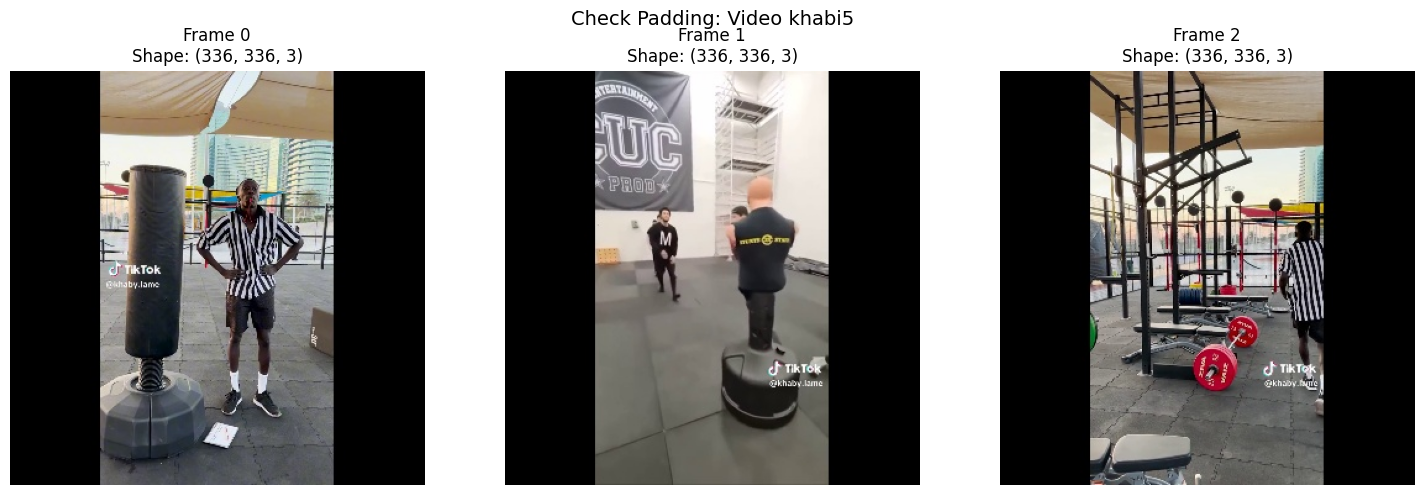

In [24]:
# ==============================================================================
# CELLA EXTRA - VISUAL CHECK (CONTROLLO VISIVO PADDING & RESIZE)
# ==============================================================================
import matplotlib.pyplot as plt
import cv2

def show_random_sample(df):
    if len(df) == 0:
        print("❌ Nessun dato da mostrare!")
        return

    # Prendi una riga a caso
    sample = df.sample(1).iloc[0]
    frames = sample['frames_paths']
    vid_id = sample['video_id']
    comment = sample['Comment']
    label = sample['Type']

    print(f"📺 VIDEO ID: {vid_id}")
    print(f"🏷️ LABEL: {label}")
    print(f"💬 COMMENT: \"{comment}\"")
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(frames):
        # Leggi immagine (BGR)
        img = cv2.imread(img_path)
        if img is not None:
            # Converti in RGB per Matplotlib
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(1, CONFIG["N_FRAMES"], i+1)
            plt.imshow(img)
            plt.title(f"Frame {i}\nShape: {img.shape}") 
            plt.axis('off')
        else:
            print(f"❌ Impossibile leggere: {img_path}")
            
    plt.suptitle(f"Check Padding: Video {vid_id}", fontsize=14)
    plt.tight_layout()
    plt.show()

print("🔍 Ispezione casuale di un elemento processato...")
show_random_sample(df_final)

In [25]:
# ==============================================================================
# CELLA 5: SPLIT STRATIFICATO "STRATEGICO"
# ==============================================================================
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd
import os

print("🔪 Avvio Split Ottimizzato ...")

# --- 1. PARAMETRI DI SPLIT (NUOVI) ---
N_ITERATIONS = 10000  # 10k tentativi per trovare l'equilibrio perfetto
VAL_RATIO = 0.125     # 12.5% -> 5 Video esatti
TEST_RATIO = 0.175    # 17.5% -> 7 Video esatti
# TRAIN rimarrà il 70% -> 28 Video

# --- 2. VINCOLI DI QUALITÀ (SAFETY CHECKS) ---
# Non accettiamo split che non rispettano questi minimi:
MIN_RACISM_TEST = 3     # Almeno 3 commenti razzisti nel Test (Smoke Test)
MIN_RACISM_TRAIN = 5    # Almeno 5 commenti razzisti nel Train (Learning)
MIN_OFFENSIVE_VAL = 30  # Almeno 30 commenti NON-NONE nel Validation (Monitoraggio Reale)

# Calcoli Tecnici
POOL_TEST_VAL = VAL_RATIO + TEST_RATIO
RELATIVE_TEST = TEST_RATIO / POOL_TEST_VAL

best_split = None
min_divergence_error = float('inf')
valid_attempts = 0

print(f"🔄 Simulazione Monte Carlo in corso ({N_ITERATIONS} iterazioni)...")

for i in range(N_ITERATIONS):
    iter_seed = CONFIG["SPLIT_SEED"] + i 
    
    # A. Split Primario: Train vs (Val+Test)
    splitter = GroupShuffleSplit(n_splits=1, test_size=POOL_TEST_VAL, random_state=iter_seed)
    train_idx, temp_idx = next(splitter.split(df_final, groups=df_final['video_id']))
    
    cand_train = df_final.iloc[train_idx]
    cand_temp = df_final.iloc[temp_idx]
    
    # B. Split Secondario: (Val+Test) -> Val vs Test
    splitter_temp = GroupShuffleSplit(n_splits=1, test_size=RELATIVE_TEST, random_state=iter_seed)
    val_idx, test_idx = next(splitter_temp.split(cand_temp, groups=cand_temp['video_id']))
    
    cand_val = cand_temp.iloc[val_idx]
    cand_test = cand_temp.iloc[test_idx]
    
    # --- 3. IL GUARDITANO (FILTRI) ---
    
    # Filtro 1: Razzismo distribuito
    n_racism_train = len(cand_train[cand_train['Type'] == 'racism'])
    n_racism_test = len(cand_test[cand_test['Type'] == 'racism'])
    if n_racism_test < MIN_RACISM_TEST: continue
    if n_racism_train < MIN_RACISM_TRAIN: continue
    
    # Filtro 2: Validation "Ricco"
    n_offensive_val = len(cand_val[cand_val['Type'] != 'none'])
    if n_offensive_val < MIN_OFFENSIVE_VAL: continue # Scarta split con validation "piatto"
    
    valid_attempts += 1
    
    # --- 4. OTTIMIZZAZIONE (CERCA LA SOMIGLIANZA TRAIN/TEST) ---
    train_dist = cand_train['Type'].value_counts(normalize=True)
    test_dist = cand_test['Type'].value_counts(normalize=True)
    
    error = 0
    all_labels = set(train_dist.index).union(set(test_dist.index))
    for label in all_labels:
        # Pesa di più le classi grandi, ma considera tutto
        t_pct = train_dist.get(label, 0)
        te_pct = test_dist.get(label, 0)
        error += abs(t_pct - te_pct)
    
    if error < min_divergence_error:
        min_divergence_error = error
        best_split = {
            "train": cand_train,
            "val": cand_val,
            "test": cand_test,
            "seed": iter_seed
        }

if best_split is None:
    raise ValueError(f"❌ IMPOSSIBILE trovare uno split valido su {N_ITERATIONS} tentativi! I vincoli sono troppo stretti.")

print(f"✅ Trovato! Su {N_ITERATIONS} iterazioni, {valid_attempts} erano valide.")
print(f"   Seed Vincente: {best_split['seed']} (Divergenza: {min_divergence_error:.4f})")

# Assegnazione
df_train = best_split["train"].copy()
df_val = best_split["val"].copy()
df_test = best_split["test"].copy()

# Leakage Check (Paranoico)
v_tr = set(df_train['video_id'])
v_va = set(df_val['video_id'])
v_te = set(df_test['video_id'])
leak = v_tr.intersection(v_te).union(v_tr.intersection(v_va)).union(v_va.intersection(v_te))
if leak: raise ValueError(f"❌ LEAKAGE RILEVATO: {leak}")

# Salvataggio
def list_to_string(lst): return "|".join(lst) if isinstance(lst, list) else str(lst)
for d in [df_train, df_val, df_test]:
    d['frames_paths'] = d['frames_paths'].apply(list_to_string)

df_train.to_csv(os.path.join(CONFIG["SPLITS_OUT_DIR"], "master_train.csv"), index=False, sep=';', encoding='utf-8')
df_val.to_csv(os.path.join(CONFIG["SPLITS_OUT_DIR"], "master_val.csv"), index=False, sep=';', encoding='utf-8')
df_test.to_csv(os.path.join(CONFIG["SPLITS_OUT_DIR"], "master_test.csv"), index=False, sep=';', encoding='utf-8')

# REPORT
print("\n📊 DISTRIBUZIONE NUOVA (70/12.5/17.5):")
print("=" * 80)
all_types = sorted(df_final['Type'].unique())
stats = []
for name, df_set in [("TRAIN", df_train), ("VAL", df_val), ("TEST", df_test)]:
    counts = df_set['Type'].value_counts()
    tot = len(df_set)
    row = {"Set": name, "Total": tot, "Videos": df_set['video_id'].nunique()}
    for t in all_types:
        c = counts.get(t, 0)
        perc = (c/tot)*100 if tot>0 else 0
        row[f"{t}"] = f"{c} ({perc:.1f}%)"
    stats.append(row)
stats_df = pd.DataFrame(stats).set_index("Set")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(stats_df)
print("=" * 80)

🔪 Avvio Split Ottimizzato ...
🔄 Simulazione Monte Carlo in corso (10000 iterazioni)...
✅ Trovato! Su 10000 iterazioni, 4857 erano valide.
   Seed Vincente: 20341 (Divergenza: 0.0100)

📊 DISTRIBUZIONE NUOVA (70/12.5/17.5):
       Total  Videos  denigration    flaming          none     racism      sexual
Set                                                                              
TRAIN   3466      28  616 (17.8%)  50 (1.4%)  2597 (74.9%)  18 (0.5%)  185 (5.3%)
VAL      710       5  136 (19.2%)   5 (0.7%)   542 (76.3%)   0 (0.0%)   27 (3.8%)
TEST     855       7  148 (17.3%)  12 (1.4%)   644 (75.3%)   5 (0.6%)   46 (5.4%)
